In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import (residual_plots, html_table,
                       reg_score_table)

pd.set_option('float_format', '{:f}'.format)

processed_data_dir = Path('../data/processed/')
file_name = 'train.csv'
file_path = processed_data_dir / file_name
models_trained_dir = Path('../models/trained/')

In [2]:
df = pd.read_csv(file_path)
df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.000000,8450,7,5,2003,2003,196.000000,706,0,150,...,0,0,0,0,1,0,0,0,1,0
1,80.000000,9600,6,8,1976,1976,0.000000,978,0,284,...,0,0,0,0,1,0,0,0,1,0
2,68.000000,11250,7,5,2001,2002,162.000000,486,0,434,...,0,0,0,0,1,0,0,0,1,0
3,60.000000,9550,7,5,1915,1970,0.000000,216,0,540,...,0,0,0,0,1,0,0,0,0,0
4,84.000000,14260,8,5,2000,2000,350.000000,655,0,490,...,0,0,0,0,1,0,0,0,1,0


### Try simple OLS
In this section I will try Ordinary Least Square Regression with formula and demostrate results differents way.

<AxesSubplot: xlabel='GrLivArea', ylabel='SalePrice'>

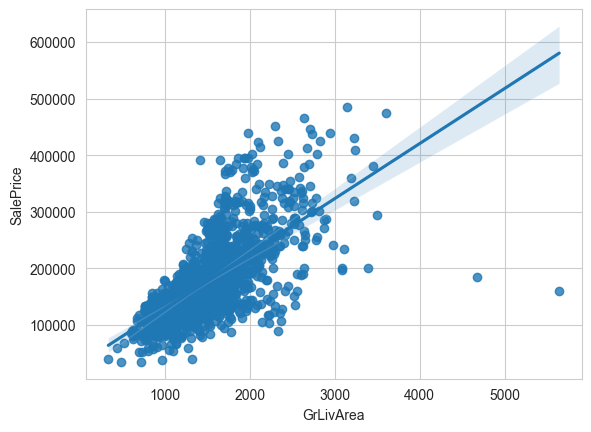

In [3]:
sns.regplot(x='GrLivArea', y='SalePrice', data=df)

In [4]:
x = df['GrLivArea'].values
y = df['SalePrice'].values
# np.polyfit(x,y,deg=1)
x_mean = x.mean()
y_mean = y.mean()
x_me = x - x_mean
y_me = y - y_mean
x_sme = np.sum(x_me ** 2)
m = np.sum(x_me * y_me) / x_sme
b = y_mean - m * x_mean
print(f'y_hat_i = {np.round(m, decimals=3)}*x_i + {np.round(b, decimals=3)}')

y_hat_i = 97.269*x_i + 31670.473


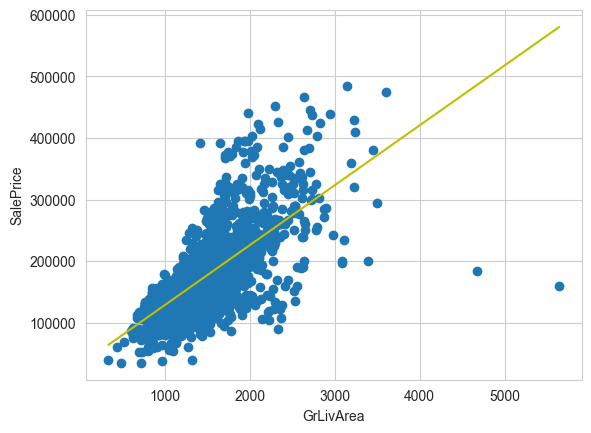

In [5]:
fig, ax = plt.subplots()
line_x = np.array([np.min(x), np.max(x)])
line_y = line_x * m + b
ax.plot(line_x, line_y, color='y')
ax.scatter(x, y)
ax.set_ylabel('SalePrice')
ax.set_xlabel('GrLivArea')
plt.show()

In [6]:
y_pred = x * m + b
R2 = 1 - (np.sum((y - y_pred) ** 2) / np.sum(y_me ** 2))

print(
    f'GrLivArea describe {np.round(R2, decimals=4) * 100}% of SalePrice\'s varience.')

GrLivArea describe 47.4% of SalePrice's varience.


In [7]:
import statsmodels.api as sm

x = sm.add_constant(x)
results = sm.OLS(y, x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     1297.
Date:                Tue, 22 Nov 2022   Prob (F-statistic):          4.12e-203
Time:                        13:59:48   Log-Likelihood:                -17704.
No. Observations:                1442   AIC:                         3.541e+04
Df Residuals:                    1440   BIC:                         3.542e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.167e+04   4285.965      7.389      0.0

### Trainin Performance Purpose Model

##### Data preparation - Trains Test Split and Feature Scaling
I didnt scale as Z scores dummy variables because they already 0-1 normalized. You can see below scaling data decrase test performance because of that on grid search only unsclaed daya used.

In [3]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
cont_cols = X.columns[:list(X.columns).index('YrSold') + 1]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[cont_cols])
X_train_scaled = np.concatenate((scaler.transform(X_train[cont_cols]),
                                 X_train.iloc[:, len(cont_cols):]), axis=1)
X_test_scaled = np.concatenate((scaler.transform(X_test[cont_cols]),
                                X_test.iloc[:, len(cont_cols):]), axis=1)

In [6]:
print(X_train_scaled.shape)
print(X_train.shape)

(1153, 263)
(1153, 263)


#### Multiple Linear Regression Models

Compare models performance on scaled and normal data.

In [7]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV

,Train Normal,Test Normal,Train Scaled,Test Scaled
R2,0.940551,0.611505,0.940551,-6444399087072656.000000
MAE,11964.188977,18585.201800,11964.790320,345035050666.333618
MSE,311424730.371365,1819284646.025320,311425439.573582,30178520219821542918324224.000000
RMSE,17647.230105,42653.073113,17647.250199,5493497994886.458984


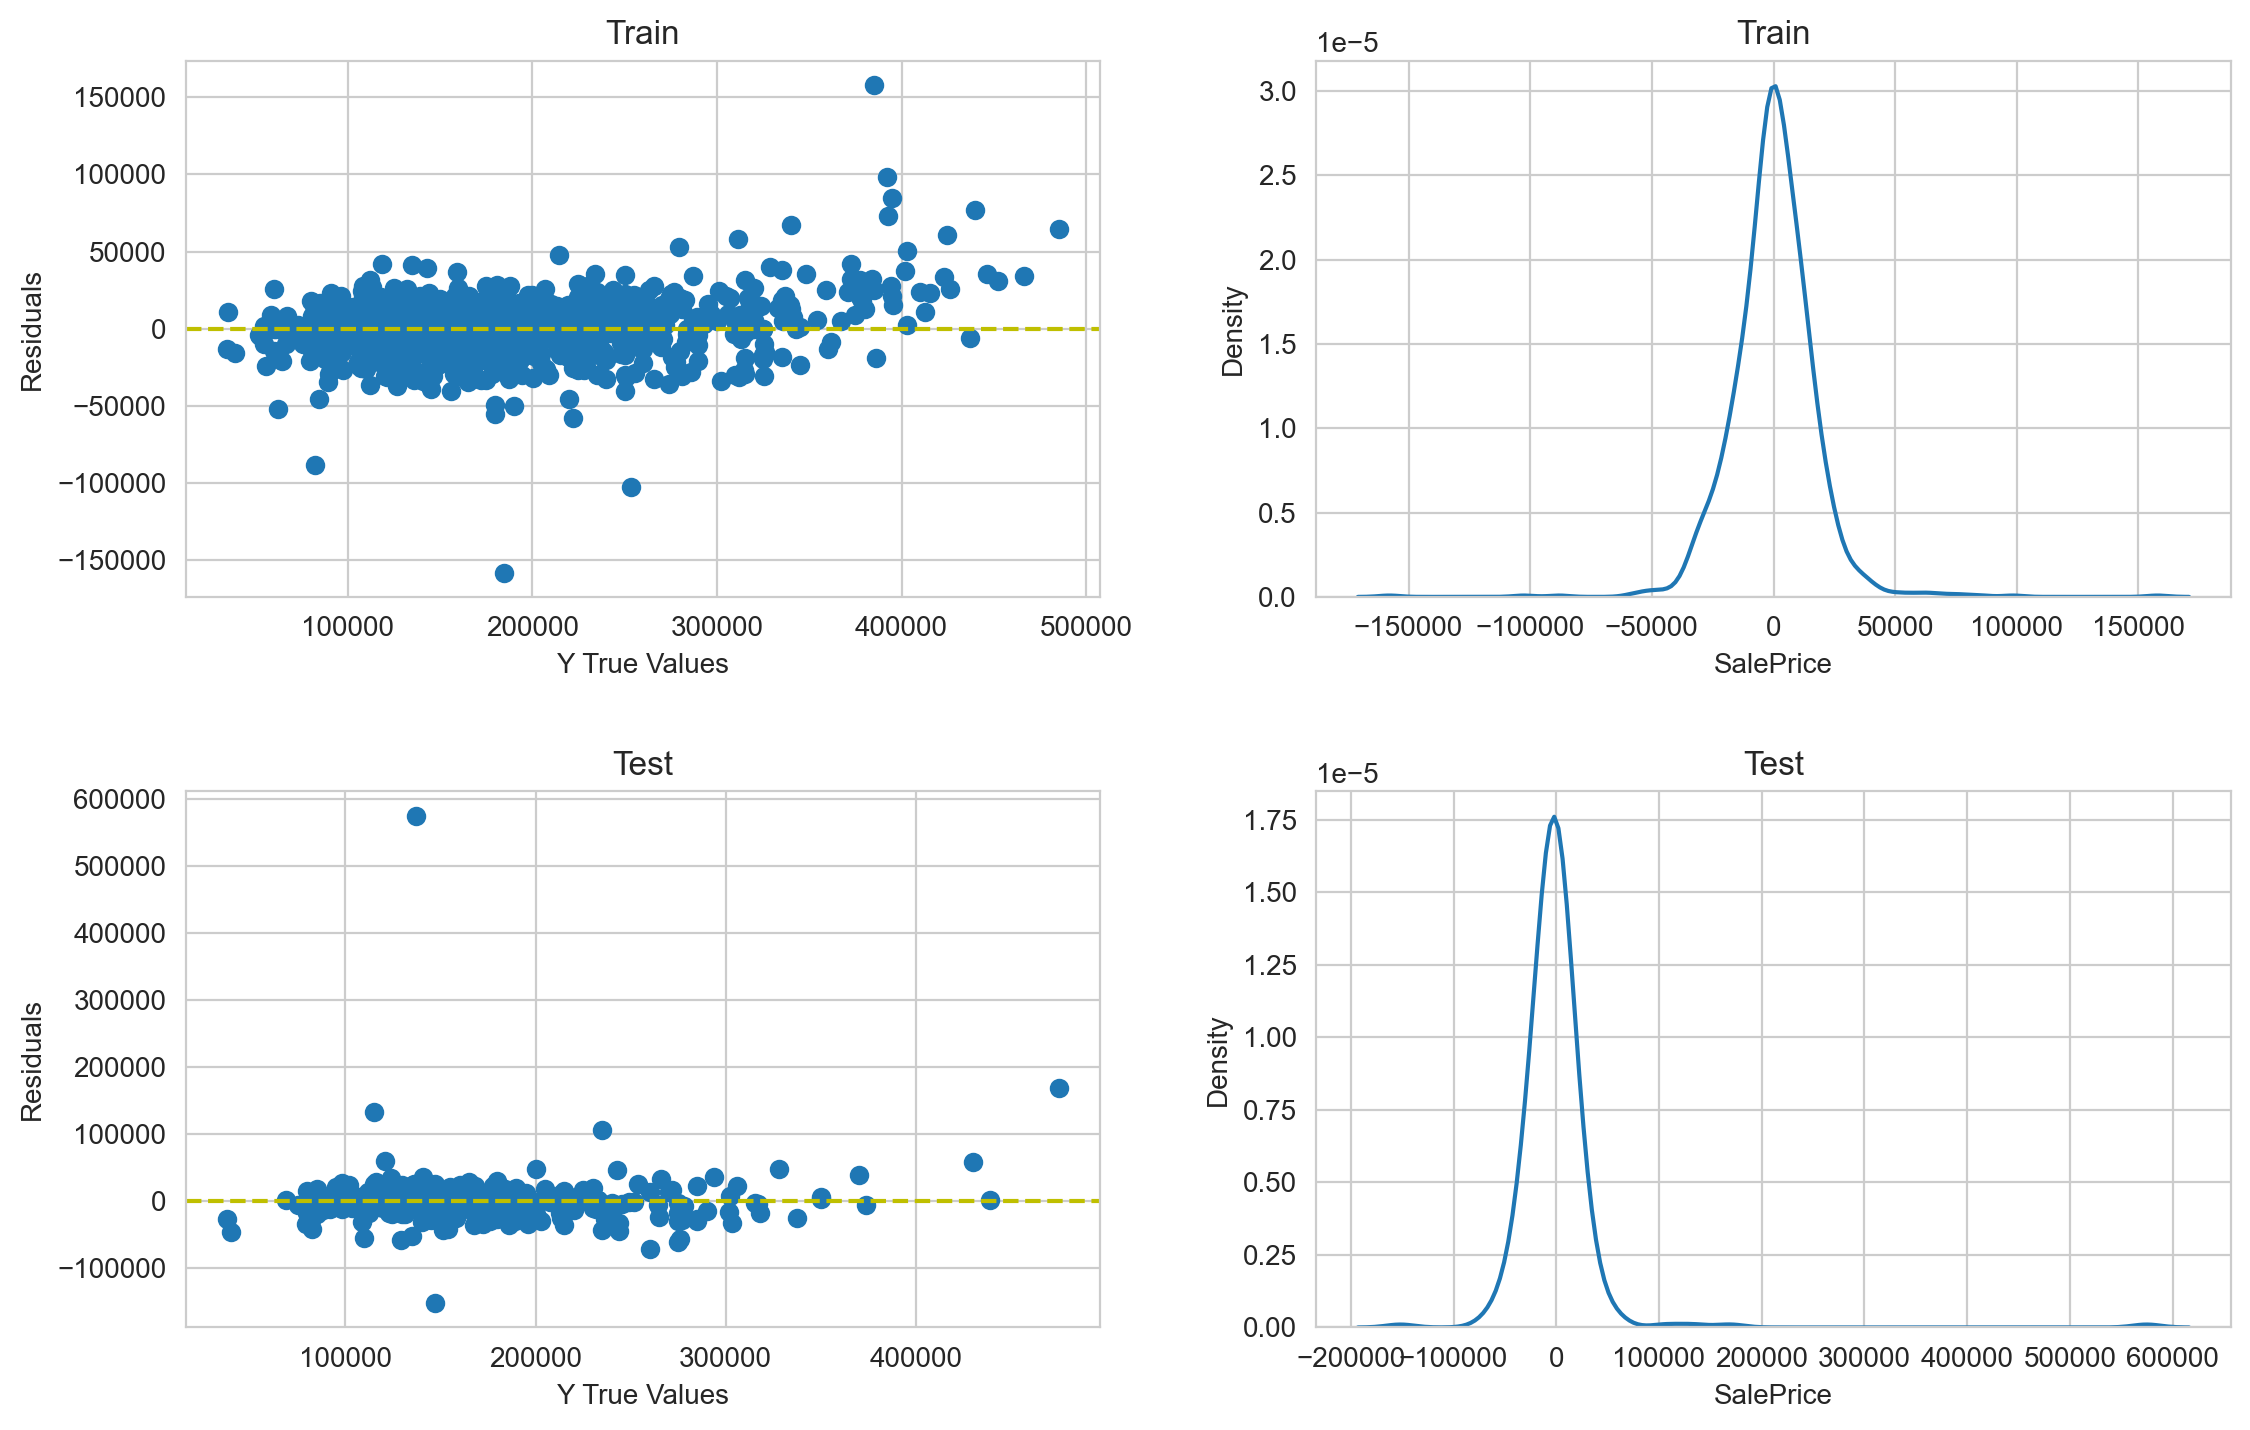

In [8]:
lin = LinearRegression()
lin.fit(X_train, y_train)
lin_scaled = LinearRegression()
lin_scaled.fit(X_train_scaled, y_train)

lin_score = reg_score_table(lin, X_train, X_test, y_train, y_test)
lin_score.columns += ' Normal'
lin_scaled_score = reg_score_table(lin_scaled, X_train_scaled, X_test_scaled,
                                   y_train, y_test)
lin_scaled_score.columns += ' Scaled'

scores = pd.concat([lin_score, lin_scaled_score], axis=1)
html_table(scores)
residual_plots(lin, X_train, X_test, y_train, y_test)

Test Polynomial Regresion Suitable for This Project

In [9]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_converter = PolynomialFeatures()
polynomial_converter.fit(X)
X_poly = polynomial_converter.transform(X)
print('Dataset features shape is: ', X_poly.shape)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,
                                                                        y,
                                                                        test_size=0.2,
                                                                        random_state=43)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train_poly)

scores = reg_score_table(poly_reg, X_train_poly, X_test_poly, y_train_poly,
                         y_test_poly)
html_table(scores)

Dataset features shape is:  (1442, 34980)


,Train,Test
R2,1.000000,-3.334672
MAE,0.000003,70704.631403
MSE,0.000000,24510679363.681435
RMSE,0.000004,156558.868684


## Grid Search on Linear Regression and Regularizations

In [10]:
def fit_eval_grid(model, params, title):
    grid = GridSearchCV(model, params,
                        scoring='neg_root_mean_squared_error', cv=5,
                        n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)
    print('\n\rBest params are: ', grid.best_params_, '\n')
    scores = reg_score_table(grid, X_train, X_test, y_train, y_test)
    scores.columns += f' {title}'
    html_table(scores)
    return grid, scores

In [11]:
lasso_model = Lasso(max_iter=int(1e+4))

lasso_param_grid = {'alpha': np.logspace(-3, 2, 10)}

lasso_grid, lasso_scores = fit_eval_grid(lasso_model, lasso_param_grid, 'Lasso')

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best params are:  {'alpha': 100.0} 



,Train Lasso,Test Lasso
R2,0.903692,0.877896
MAE,14968.941097,15698.198618
MSE,504515378.656862,571803188.905647
RMSE,22461.419783,23912.406590


In [13]:
ridge_model = Ridge(max_iter=int(1e+4))

ridge_param_grid = {'alpha': np.logspace(-3, 2, 10)}

ridge_grid, ridge_scores = fit_eval_grid(ridge_model, ridge_param_grid, 'Ridge')

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best params are:  {'alpha': 7.742636826811277} 



,Train Ridge,Test Ridge
R2,0.907920,0.877607
MAE,14680.604438,15813.042810
MSE,482365427.570502,573152767.442784
RMSE,21962.819208,23940.609170


In [14]:
elastic_model = ElasticNet(max_iter=int(1e+3))

elastic_param_grid = {'alpha': [0.1, 1, 5, 10, 50, 100],
                      'l1_ratio': [.1, .5, .7, .9, .95, .99, 1]}

elastic_grid, elastic_scores = fit_eval_grid(elastic_model, elastic_param_grid,
                                             'Elastic')

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best params are:  {'alpha': 1, 'l1_ratio': 0.99} 



,Train Elastic,Test Elastic
R2,0.904083,0.879543
MAE,14821.688448,15731.422848
MSE,502466911.922032,564086951.707294
RMSE,22415.773730,23750.514767


In [15]:
all_scores = pd.concat((lin_score, lasso_scores, ridge_scores, elastic_scores),
                       axis=1)
html_table(all_scores)

,Train Normal,Test Normal,Train Lasso,Test Lasso,Train Ridge,Test Ridge,Train Elastic,Test Elastic
R2,0.940551,0.611505,0.903692,0.877896,0.907920,0.877607,0.904083,0.879543
MAE,11964.188977,18585.201800,14968.941097,15698.198618,14680.604438,15813.042810,14821.688448,15731.422848
MSE,311424730.371365,1819284646.025320,504515378.656862,571803188.905647,482365427.570502,573152767.442784,502466911.922032,564086951.707294
RMSE,17647.230105,42653.073113,22461.419783,23912.406590,21962.819208,23940.609170,22415.773730,23750.514767
